# NER SPACY Training

## First Step (MarkUp our datasets)
- special `.spacy` file, in which you have markup tags in all text  

```
{
    "text": "Купить iPhone 15 Pro Max по выгодной цене",
    "entities": [(6, 20, "PRODUCT")]  # iPhone 15 Pro Max
}
```

In [ ]:
import re
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
from spacy.util import filter_spans


def mark_and_save_spacy(df, output_path, label="PRODUCT"):
    nlp = spacy.blank("en")
    doc_bin = DocBin()
    total_targets = 0
    found_targets = 0
    skipped_texts = 0

    for _, row in tqdm(df.iterrows(), total=len(df), desc="📌 Разметка"):
        targets = str(row['Informative_Text'])
        text = str(row['Texts'])
        entities = []

        for target in targets.split(','): # prepare tags
            target = target.strip()
            
            if not target:
                continue
            
            total_targets += 1
            
            matched = False
            for match in re.finditer(re.escape(target), text, flags=re.IGNORECASE): # find matches
                start, end = match.span()                                           
                entities.append((start, end, label))                                
                matched = True
            
            if matched:
                found_targets += 1

        # skip texts without markup targets
        if not entities:
            skipped_texts += 1
            continue

        doc = nlp.make_doc(text)
        spans = [doc.char_span(start, end, label=label) for start, end, label in entities]
        spans = [s for s in spans if s is not None]
        spans = filter_spans(spans)
        doc.ents = spans
        doc_bin.add(doc)

    doc_bin.to_disk(output_path)
    print(f"\n Размеченные данные сохранены в {output_path}")
    print(f"⏭ Пропущено текстов без сущностей: {skipped_texts}")
    if total_targets > 0:
        coverage = found_targets / total_targets * 100
        print(f"Найдено {found_targets}/{total_targets} таргетов ({coverage:.2f}%)")
    else:
        print("Нет ни одного таргета в данных.")

## Second Step (Calculate F1 Metric)

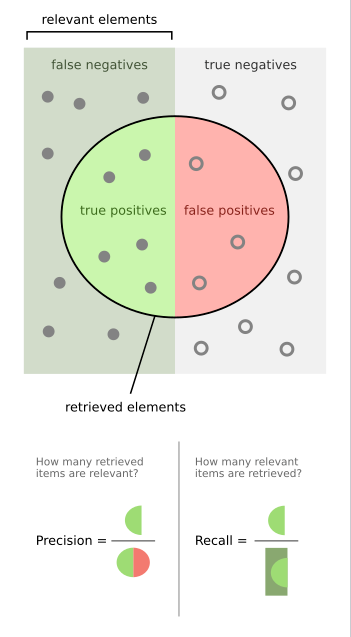

Precision = TruePositives + FalsePositives / TruePositives

Recall = TruePositives + FalseNegatives / TruePositives
​
- **True Positives (TP)**: Correctly predicted positive instances.
- **False Positives (FP)**: Incorrectly predicted positive instances.
- **True Negatives (TN)**: Correctly predicted negative instances.
- **False Negatives (FN)**: Incorrectly predicted negative instances.

F_1 = (2 × Precision + Recall) / Precision × Recall

In [6]:
from sklearn.metrics import f1_score

def evaluate_ner_model(nlp, examples, label="PRODUCT", verbose=True):
    y_true = []
    y_pred = []

    for example in examples:
        pred_doc = nlp(example.text)
        pred_ents = {(ent.start_char, ent.end_char) for ent in pred_doc.ents if ent.label_ == label}
        true_ents = {(ent.start_char, ent.end_char) for ent in example.reference.ents if ent.label_ == label}

        y_true.append(true_ents)
        y_pred.append(pred_ents)

    """
    Бинаризация по сущностям (совпадает ли хотя бы одна сущность по позиции)
    Пример:
        Пусть y_true содержит: [{(0, 5)}, {(10, 15)}] (две сущности).
        Пусть y_pred содержит: [{(0, 5)}] (одна сущность).
    
    В результате:
        Для первого примера: true_labels получит 1, pred_labels получит 1.
        Для второго примера: true_labels получит 1, pred_labels получит 0 (потому что y_pred пустой).
    """
    true_labels = []
    pred_labels = []

    for t_set, p_set in zip(y_true, y_pred):
        true_labels.append(1 if t_set else 0)
        pred_labels.append(1 if p_set else 0)

    f1 = f1_score(true_labels, pred_labels)
    if verbose:
        print(f"F1 для {label}: {f1:.2f}")
    return f1

### additional features

In [4]:
def load_spacy_data(path):
    doc_bin = DocBin().from_disk(path)
    return list(doc_bin.get_docs(spacy.blank("en").vocab))

In [5]:
import os
#from google.colab import files


# Сохранение и скачивание модели
def save_and_download_model(model, model_name):
    output_dir = f"/content/{model_name}"
    model.to_disk(output_dir)

    # Создаём zip-архив для скачивания
    os.system(f"zip -r {model_name}.zip {output_dir}")
    #files.download(f"{model_name}.zip")
    print(f"Модель {model_name} сохранена и готова к скачиванию.")

## Third Step (Train PreTrained model)

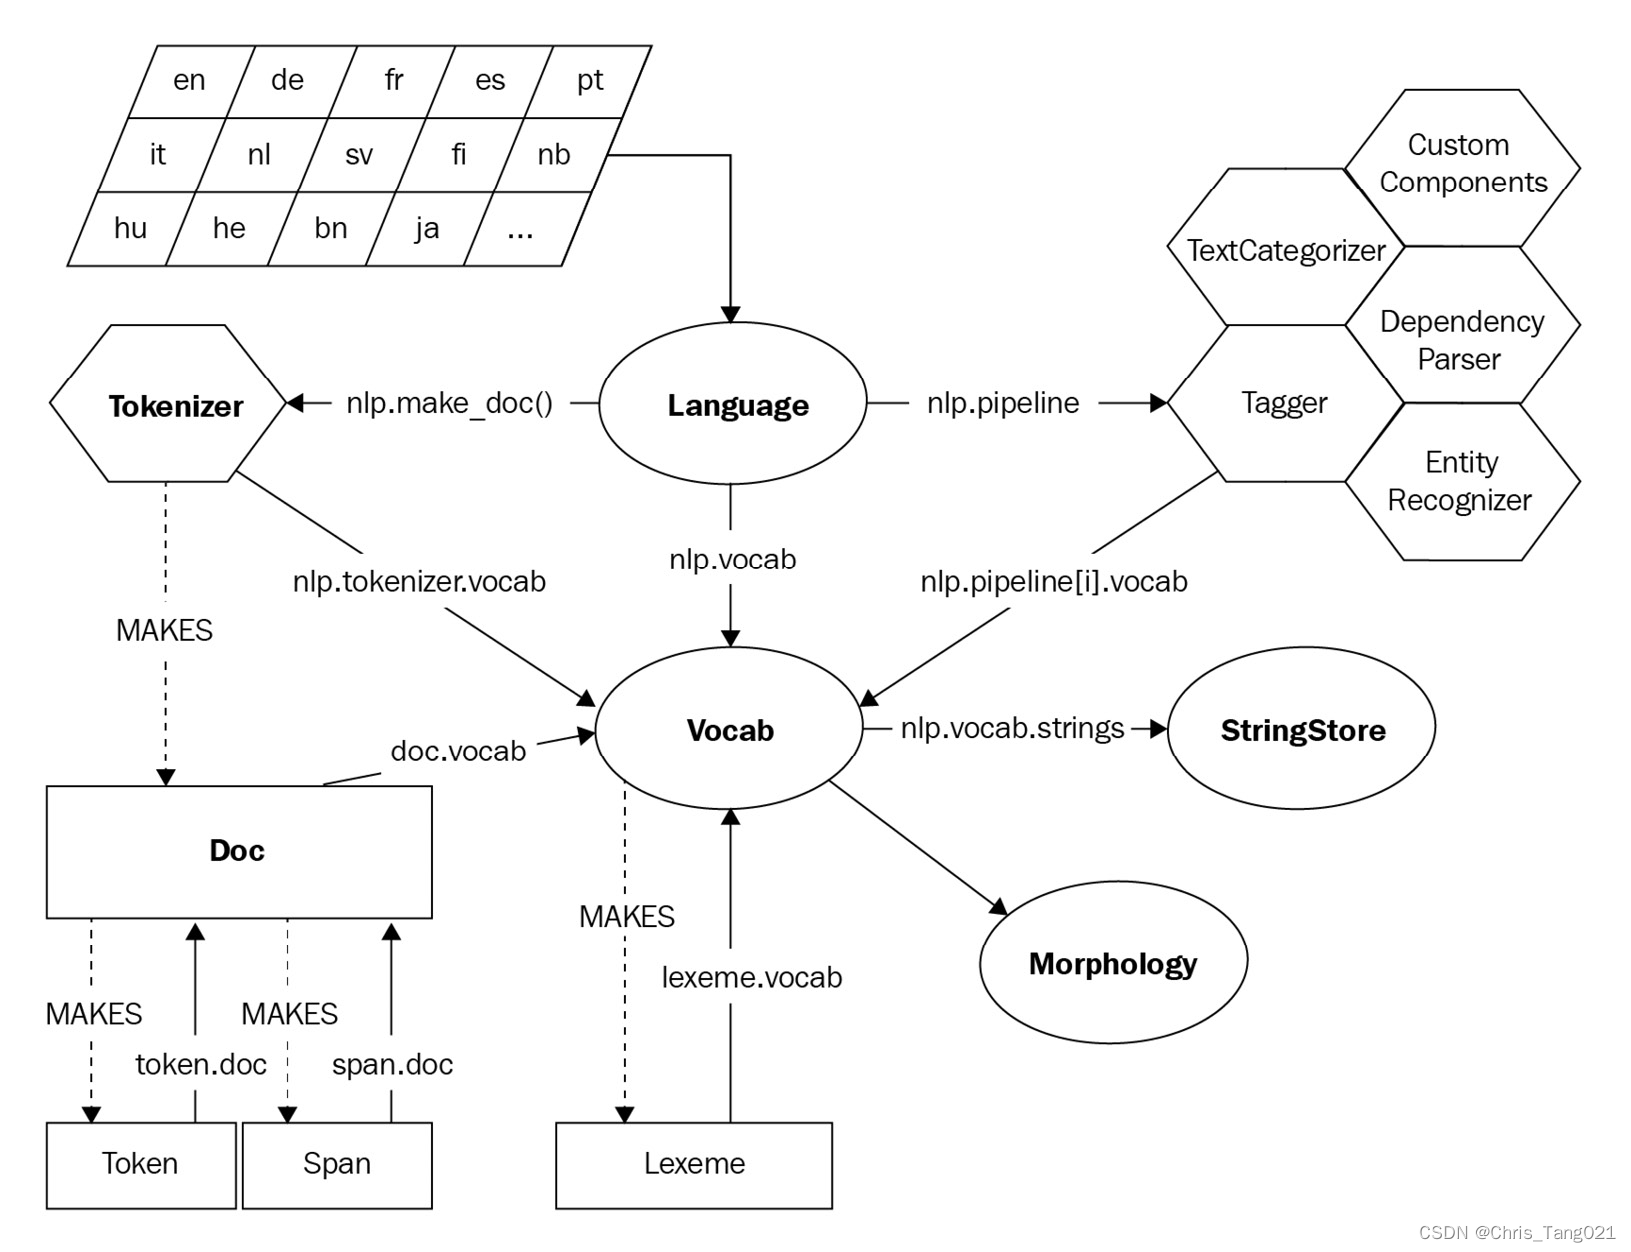

`model_name="en_core_web_sm"` - pretrained model


In [7]:
from spacy.training import Example
from sklearn.model_selection import KFold
from tqdm import trange
import random
import numpy as np


def train_with_cv(input_paths, n_iter=10, model_name="en_core_web_sm", n_folds=2, label="PRODUCT"):
    # load folds
    docs = load_spacy_data(input_paths[0])
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    if not docs:
        print("Нет документов.")
        return None

    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(docs), 1):
        print(f"\n Начало обучения для фолда {fold}/{n_folds}")
        train_docs = [docs[i] for i in train_idx]
        test_docs = [docs[i] for i in test_idx]

        nlp = spacy.load(model_name) # pretrained model

        # add pipe ner
        if "ner" not in nlp.pipe_names: 
            ner = nlp.add_pipe("ner", last=True)
        else:
            ner = nlp.get_pipe("ner")

        ner.add_label(label) 

        # model trained by Examples
        train_examples = [Example(doc, doc) for doc in train_docs] 
        test_examples = [Example(doc, doc) for doc in test_docs]

        optimizer = nlp.resume_training() 
        optimizer.L2 = 0.01

        best_f1 = 0
        for epoch in trange(n_iter, desc=f"Обучение фолда {fold}"):
            random.shuffle(train_examples)
            losses = {}
            nlp.update(train_examples, drop=0.3, losses=losses, sgd=optimizer)
            print(f"📉 Фолд {fold} | Epoch {epoch+1} — Loss: {losses.get('ner', 0):.4f}")

            current_f1 = evaluate_ner_model(nlp, test_examples, label, verbose=False)
            if current_f1 > best_f1:
                best_f1 = current_f1

        fold_results.append(best_f1)
        print(f"🏆 Лучший F1 для фолда {fold}: {best_f1:.4f}")

    print("\nРезультаты кросс-валидации:")
    for fold, f1 in enumerate(fold_results, 1):
        print(f"Фолд {fold}: F1 = {f1:.4f}")
    print(f"Средний F1: {np.mean(fold_results):.4f}")

    return nlp

## MAIN

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from spacy.training import Example

def main():
    CSV_PATH = "dataset_result.csv"
    OUTPUT_DIR = "fold_data"
    TEST_SIZE = 0.2
    N_FOLDS = 2
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    df = pd.read_csv(CSV_PATH)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True) 

    # train/test
    train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=42)

    # save test .spacy
    test_path = os.path.join(OUTPUT_DIR, "test.spacy")
    mark_and_save_spacy(test_df, test_path)

    # save train .spacy
    train_path = os.path.join(OUTPUT_DIR, "train.spacy")
    mark_and_save_spacy(train_df, train_path)

    trained_nlp = train_with_cv([train_path], 10, N_FOLDS, 42)

    if trained_nlp:
        # save&download model
        trained_nlp.to_disk("trained_model")
        save_and_download_model(trained_nlp, 'trained_model')
        print("Модель сохранена в 'trained_model'")

        # test
        print("\n Тестирование модели:")
        test_docs = load_spacy_data(test_path)
        test_examples = [Example(doc, doc) for doc in test_docs if len(doc.ents) > 0]

        if test_examples:
            test_f1 = evaluate_ner_model(trained_nlp, test_examples, verbose=True)
            print(f"\nРезультаты на тестовой выборке:")
            print(f"F1-score: {test_f1:.4f}")
        else:
            print("!!! Нет документов для тестирования")

if __name__ == "__main__":
    main()

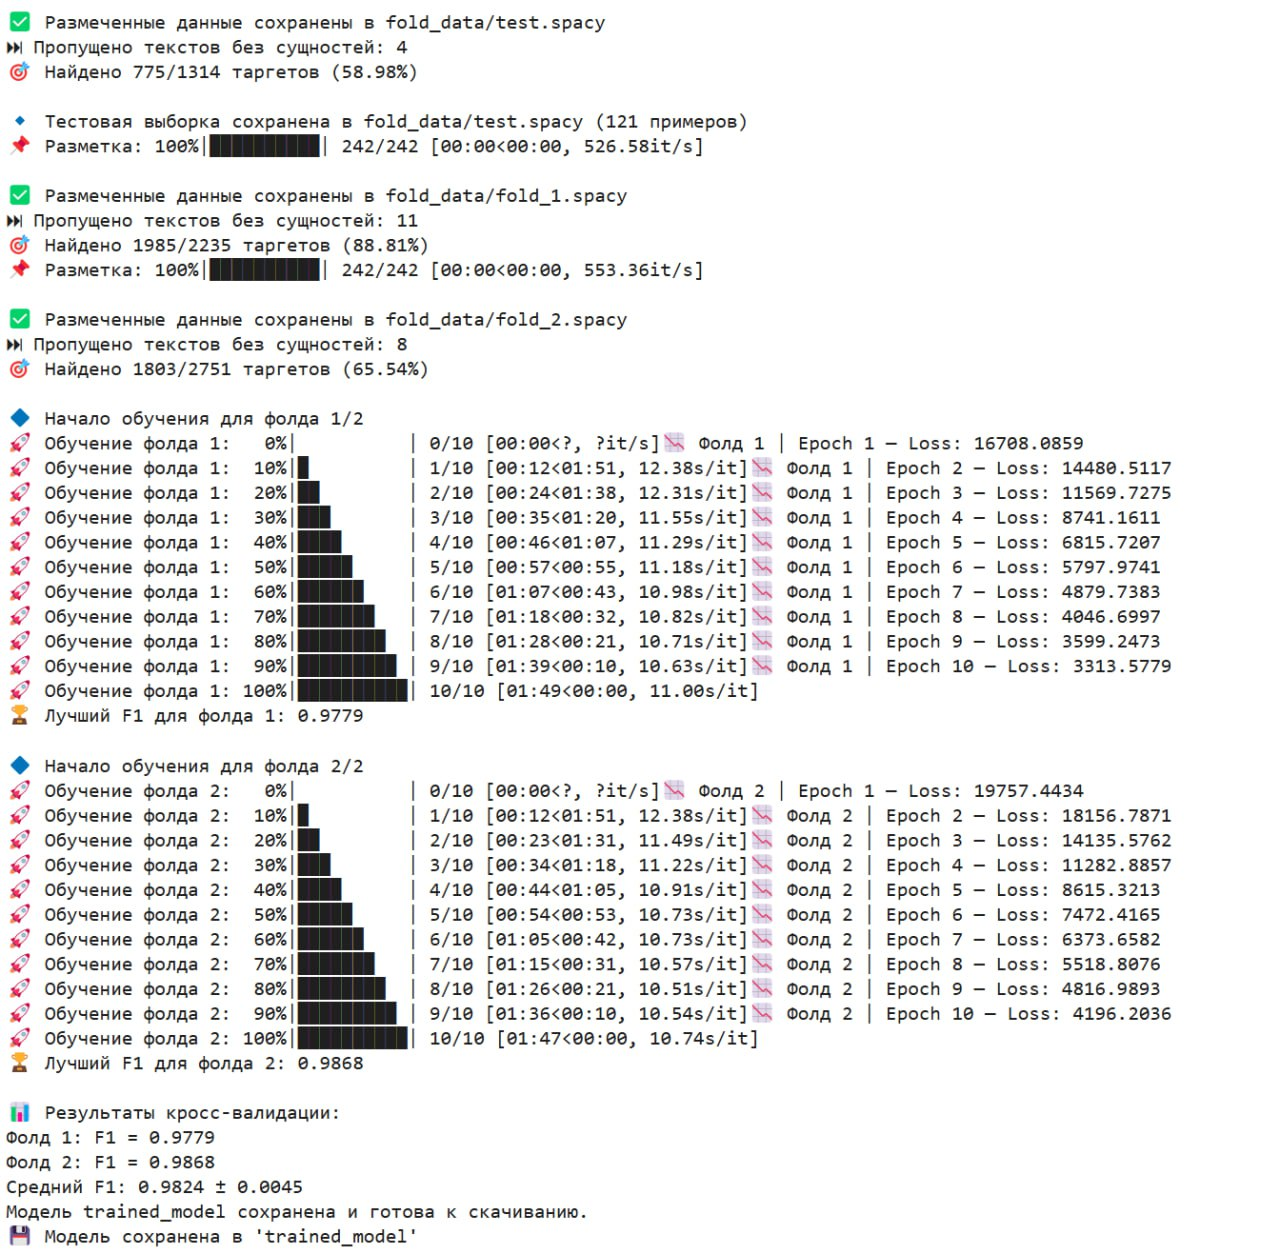